In [3]:
import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal

In [4]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


In [5]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city
# PartList = [365, 1754, 2258, 2693, 3310, 4176, 4597, 4796, 4917, 5741, 6642, 7093, 7264, 7412, 7842, 8007, 8469, 8673, 9472, 9502, 9586, 9601]

PartList = [1004, 1005, 1008, 1010, 1011, 1013, 1017, 1018, 1019, 1021, 1022, 1023, 1054, 1055, 1056, 1057, 1058, 1068, 1069, 1072, 1073, 1074, 1075, 1077, 1079, 1080]
print(len(PartList),'participants') 

26 participants


In [14]:
datapath = "F:\\WestbrookProject\\Spa_Re\\control_group\\pre-processing_2023\\velocity_based\\step1_dupl_clean_smooth"
            

# datapath = "F:\\WestbrookProject\\HumanA_Data\\Experiment1\\Exploration_short\\pre-processing\\velocity_based\\step1_dupl_clean_smooth"
savepath = "F:\\Cyprus_project_overview\\data\\analysis\\walkingSpeed"


savepath_walkingPaths = "F:\\WestbrookProject\\Spa_Re\\control_group\\analysis_velocityBased_2023"


## walking distance and walking speed functions

In [8]:
# Define a function to calculate Euclidean distance between two points
def euclidean_distance(row1, row2):
#     return np.sqrt((row2['hmdPosition_x'] - row1['hmdPosition_x'])**2 + 
#                    (row2['hmdPosition_y'] - row1['hmdPosition_y'])**2 + 
#                    (row2['hmdPosition_z'] - row1['hmdPosition_z'])**2)

    return np.sqrt((row2['playerBodyPosition_x'] - row1['playerBodyPosition_x'])**2 + 
                   (row2['playerBodyPosition_z'] - row1['playerBodyPosition_z'])**2)

In [9]:
def calc_walkingSpeed(df):


    
    # Calculate the distance between consecutive rows
    distances = []
    for i in range(len(df) - 1):
        distance = euclidean_distance(df.iloc[i], df.iloc[i + 1])
        distances.append(distance)
    
    
    # Add distances as a new column in DataFrame (with NaN for the last row)
    df['distances_m'] = [np.nan] + distances

    # Calculate time differences between rows
    df['time_diff'] = df['timeStampDataPointStart_converted'].diff().fillna(0)

    # Calculate speed in km/h
    # Speed (km/h) = (Distance (meters) / Time (seconds)) * 3.6
    df['speed_kmh'] = (df['distances_m']/df['time_diff']) * 3.6
    df['speed_kmh'].fillna(0, inplace=True)  # Fill NaN values (if any) with 0 for the first row

    return df
    
    

In [41]:

def calc_walkingSpeed_rate(df, rate):
    # Create a mask to select every 90th row
    mask = np.zeros(len(df), dtype=bool)
    mask[::rate] = True
    
    # Apply the mask to filter the DataFrame
    df_filtered = df[mask]
    
    # Calculate the distance between consecutive rows in the filtered DataFrame
    distances = []
    for i in range(len(df_filtered) - 1):
        distance = euclidean_distance(df_filtered.iloc[i], df_filtered.iloc[i + 1])
        distances.append(distance)
    
    # Add distances as a new column in the filtered DataFrame (with NaN for the last row)
    df_filtered['distances_m'] = [np.nan] + distances
    
    # Calculate time differences between rows in the filtered DataFrame
    df_filtered['time_diff'] = df_filtered['timeStampDataPointStart_converted'].diff().fillna(0)
    
    # Calculate speed in km/h
    # Speed (km/h) = (Distance (meters) / Time (seconds)) * 3.6
    df_filtered['speed_kmh'] = (df_filtered['distances_m'] / df_filtered['time_diff']) * 3.6
    df_filtered['speed_kmh'].fillna(0, inplace=True)  # Fill NaN values (if any) with 0 for the first row
    
    # Return only the speed values
    return df_filtered['speed_kmh'].values , df_filtered['distances_m'].values

## loop over file and calculate the walking speed and distance only considering every 45th row

In [58]:
print('start')
# walking speed lists

allWalkingSpeeds = []
allWalkingSpeed_means = []

allWalkingDistances = []
allWalkingDistances_parts = []



# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    speed_part = []
    dist_part = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:
        

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(datapath) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_dupl_clean_smooth.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            dataVR = pd.read_csv(os.path.join(datapath, file))
            
            speed, distances = calc_walkingSpeed_rate(dataVR, 45)
                
            # add speed info to overview
            allWalkingSpeeds.extend(speed)  # Append speeds to the global list
            speed_part.extend(speed)  # Append speeds for the current session
            
            # add distances to overview
            sumDist = sum(x for x in distances if not math.isnan(x))

            allWalkingDistances.append(sumDist)
            dist_part.append(sumDist)
            
            
            del dataVR 

    # Calculate mean speed for the current session and store it
    if speed_part:  # Check if the list is not empty
        mean_speed = np.nanmean(speed_part)
        allWalkingSpeed_means.append(mean_speed)
        
    # Calculate distance for the current session and store it
    if dist_part:  # Check if the list is not empty
        sumDist_part = sum(dist_part)
        allWalkingDistances_parts.append(sumDist_part)

        


if len(missingFiles)>0:
    
    print("missing files detected")
    print(missingFiles)
    
else:
    print("All files were found")


start


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_dupl_clean_smooth.csv


D:\Software\Programme\Anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
D:\Software\Programme\Anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Software\Programme\Anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

process file  1004_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1010_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_5_ET_3_data_dupl_clean_smooth.csv
process file  1010_Session_5_ET_4_data_dupl_clean_smooth.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1011_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1017_Session_1_ET_4_data_dupl_clean_smooth.csv
process file  1017_Session_1_ET_5_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1018_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_4_ET_3_data_dupl_clean_smooth.csv
process file  1019_Session_4_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_5_ET_3_data_dupl_clean_smooth.csv
process file  1021_Session_5_ET_4_data_dupl_clean_smooth.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_4_ET_3_data_dupl_clean_smooth.csv
process file  1055_Session_4_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1058_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1068_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_5_ET_3_data_dupl_clean_smooth.csv
All files were found


In [81]:
print('-------- sanity checks file lengths -------------')
print(len(allWalkingSpeeds))
print(len(allWalkingSpeed_means))

print(len(allWalkingDistances))
print(len(allWalkingDistances_parts))

print('-------- walking speeds stats of all data (independent of participants) -------------')

print('min speed: ' , np.nanmin(allWalkingSpeeds), 'km/h')
print('max speed: ' , np.nanmax(allWalkingSpeeds), 'km/h')
print('mean speed: ', np.nanmean(allWalkingSpeeds), 'km/h')
print('median speed: ', np.nanmedian(allWalkingSpeeds), 'km/h')

print('---------walking speed means for each participant------------')

print('slowest participant mean', min(allWalkingSpeed_means), 'km/h')
print('fastest participant mean', max(allWalkingSpeed_means), 'km/h')
print('grand mean ', np.mean(allWalkingSpeed_means), 'km/h')




print('--------- walking distances for 1 file (10min) stats ------------')

print('min distance: ' , np.nanmin(allWalkingDistances)/1000, 'km')
print('max distance: ' , np.nanmax(allWalkingDistances)/1000, 'km')
print('mean distance: ', np.nanmean(allWalkingDistances)/1000, 'km')
print('median distance: ', np.nanmedian(allWalkingDistances)/1000, 'km')

print('sum all dist / 26: ', (sum(allWalkingDistances)/1000)/26, 'km')

exp = 5* (1/60)
print('expectation for 10 min, if walking speed is 5km/h = ', exp , 'km')


print('---------------------')

print('range of walking distances for each participant ')
print('Participant with min walking distance', min(allWalkingDistances_parts)/1000, 'km')
print('Participant with max walking distance', max(allWalkingDistances_parts)/1000, 'km')

print('mean walking distance ', np.mean(allWalkingDistances_parts)/1000, 'km')


print('---------------------')
print('Walking distance of a walking speed of 5 km/h for 150 min')
walkingTime = 2.5 # hours
walkingSpeed = 5 # km/h

print(walkingTime * walkingSpeed , 'km')

print((walkingTime * walkingSpeed)*1000 , 'm')

print('Walking distance of a walking speed of 5 km/h for 150 min in comparison of mean walking distance in VR should be around: ', (walkingTime * walkingSpeed), 'km')
print('mean walking distance ', np.mean(allWalkingDistances_parts)/1000, 'km')

print('5km/h dist / walked mean dist: ', (walkingTime * walkingSpeed)/(np.mean(allWalkingDistances_parts)/1000))
print( 'in VR they walked ', (np.mean(allWalkingDistances_parts)/1000)/(walkingTime * walkingSpeed), 'times what they should have with a 5 km/h speed limit')

-------- sanity checks file lengths -------------
334143
26
401
26
-------- walking speeds stats of all data (independent of participants) -------------
min speed:  0.0 km/h
max speed:  18.494905806732227 km/h
mean speed:  12.929803763658317 km/h
median speed:  16.669885160375586 km/h
---------walking speed means for each participant------------
slowest participant mean 6.941375692916728 km/h
fastest participant mean 17.104781779727745 km/h
grand mean  12.930882022084525 km/h
--------- walking distances for 1 file (10min) stats ------------
min distance:  0.0 km
max distance:  2.9381146740180184 km
mean distance:  2.093633003435289 km
median distance:  2.247395035546262 km
sum all dist / 26:  32.29026286067503 km
expectation for 10 min, if walking speed is 5km/h =  0.08333333333333333 km
---------------------
range of walking distances for each participant 
Participant with min walking distance 17.302470026988967 km
Participant with max walking distance 42.761561587713466 km
mean walki

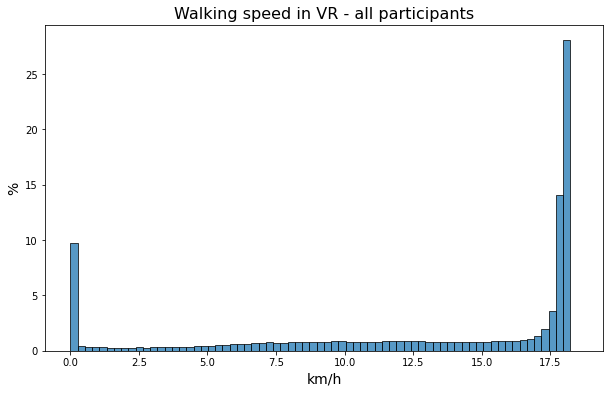

In [68]:
# Example data

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(allWalkingSpeeds,kde=False, stat='percent')


# Add labels and title
plt.xlabel('km/h', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.title('Walking speed in VR - all participants', fontsize=16)

full_path = os.path.join(savepath_walkingPaths, "walkingSpeed_VR_allParticipants.png")

plt.savefig(full_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

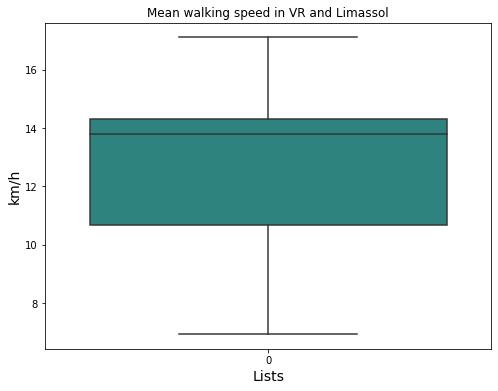

In [69]:

plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=allWalkingSpeed_means, palette='viridis')


# Add labels and title
plt.xlabel('Lists', fontsize=14)
plt.ylabel('km/h', fontsize=14)
plt.title('Mean walking speed in VR and Limassol', fontsize=12)

# save plot

full_path = os.path.join(savepath_walkingPaths, "mean_walking_speeds")

plt.savefig(full_path, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

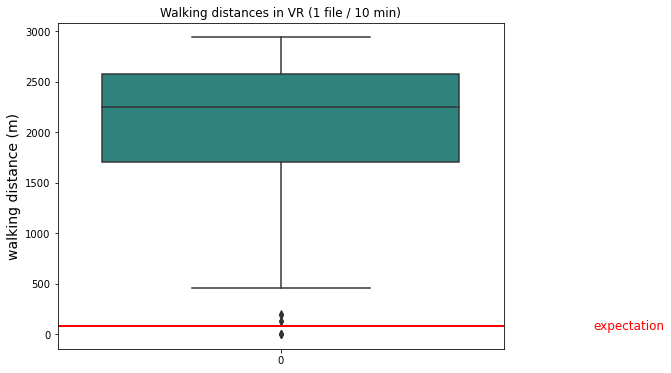

In [82]:

plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=allWalkingDistances, palette='viridis')

exp_dist = (5 * (1/60)) * 1000 # 5km/h for 10 min in m 
# Add a horizontal line representing the Limassol value
plt.axhline(y=exp_dist, color='red', linestyle='-', linewidth=2)

# Add a label next to the axline
plt.text(x=0.7, y=exp_dist, s='expectation', color='red', fontsize=12, verticalalignment='center')
# 

# Add labels and title
plt.ylabel('walking distance (m)', fontsize=14)
plt.title('Walking distances in VR (1 file / 10 min)', fontsize=12)

# save plot

full_path = os.path.join(savepath_walkingPaths, 'walking_distances_Westbrook_1file_10min')

plt.savefig(full_path, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

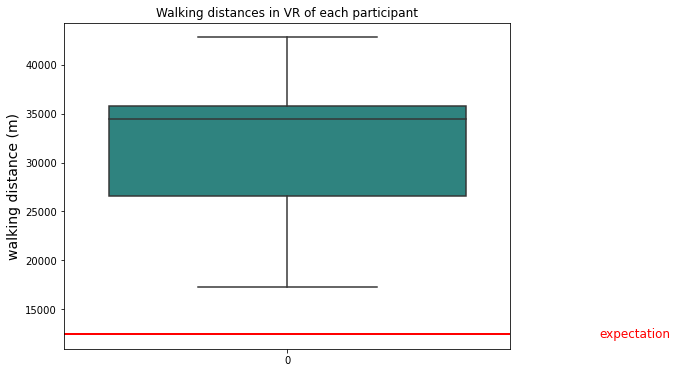

In [83]:

plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=allWalkingDistances_parts, palette='viridis')

exp_m_all = (5* 2.5)*1000 # 5km/h for 150min/2.5 hours in m
# Add a horizontal line representing the Limassol value
plt.axhline(y=exp_m_all, color='red', linestyle='-', linewidth=2)

# Add a label next to the axline
plt.text(x=0.7, y=exp_m_all, s='expectation', color='red', fontsize=12, verticalalignment='center')


# Add labels and title
plt.ylabel('walking distance (m)', fontsize=14)
plt.title('Walking distances in VR of each participant', fontsize=12)

# save plot

full_path = os.path.join(savepath_walkingPaths, 'walking_distances_Westbrook_participants')

plt.savefig(full_path, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

## do the same loop for each row and also do all the plots

In [85]:
print('start')
# walking speed lists

allWalkingSpeeds = []
allWalkingSpeed_means = []

allWalkingDistances = []
allWalkingDistances_parts = []



# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    speed_part = []
    dist_part = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:
        

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(datapath) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_dupl_clean_smooth.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            dataVR = pd.read_csv(os.path.join(datapath, file))
            
            dataVR = calc_walkingSpeed(dataVR)
                
            # add speed info to overview
            speed = dataVR['speed_kmh'].values
            allWalkingSpeeds.extend(speed)  # Append speeds to the global list
            speed_part.extend(speed)  # Append speeds for the current session
            
            # add distances to overview
            distances = dataVR['distances_m'].values
            sumDist = sum(x for x in distances if not math.isnan(x))

            allWalkingDistances.append(sumDist)
            dist_part.append(sumDist)
            
            
            del dataVR 

    # Calculate mean speed for the current session and store it
    if speed_part:  # Check if the list is not empty
        mean_speed = np.nanmean(speed_part)
        allWalkingSpeed_means.append(mean_speed)
        
    # Calculate distance for the current session and store it
    if dist_part:  # Check if the list is not empty
        sumDist_part = sum(dist_part)
        allWalkingDistances_parts.append(sumDist_part)

        


if len(missingFiles)>0:
    
    print("missing files detected")
    print(missingFiles)
    
else:
    print("All files were found")


start


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1004_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1004_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1005_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1005_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1008_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1008_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1010_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1010_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1010_Session_5_ET_3_data_dupl_clean_smooth.csv
process file  1010_Session_5_ET_4_data_dupl_clean_smooth.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1011_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1011_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1011_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1013_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1013_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1017_Session_1_ET_4_data_dupl_clean_smooth.csv
process file  1017_Session_1_ET_5_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1017_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1017_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1018_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1018_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1018_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_4_ET_3_data_dupl_clean_smooth.csv
process file  1019_Session_4_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1019_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1019_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1021_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1021_Session_5_ET_3_data_dupl_clean_smooth.csv
process file  1021_Session_5_ET_4_data_dupl_clean_smooth.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1022_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1022_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1023_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1023_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1054_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1054_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_4_ET_3_data_dupl_clean_smooth.csv
process file  1055_Session_4_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1055_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1055_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1056_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1056_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1057_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1057_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1058_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1058_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1058_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_1_ET_3_data_dupl_clean_smooth.csv
process file  1068_Session_1_ET_4_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1068_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1068_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1069_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1069_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1072_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1072_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1073_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1073_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1074_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1074_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1075_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1075_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1077_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1077_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1079_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1079_Session_5_ET_3_data_dupl_clean_smooth.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_1_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_1_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_2_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_2_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_3_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_3_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_4_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_4_ET_3_data_dupl_clean_smooth.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_dupl_clean_smooth.csv
process file  1080_Session_5_ET_2_data_dupl_clean_smooth.csv
process file  1080_Session_5_ET_3_data_dupl_clean_smooth.csv
All files were found


In [86]:
print('-------- sanity checks file lengths -------------')
print(len(allWalkingSpeeds))
print(len(allWalkingSpeed_means))

print(len(allWalkingDistances))
print(len(allWalkingDistances_parts))

print('-------- walking speeds stats of all data (independent of participants) -------------')

print('min speed: ' , np.nanmin(allWalkingSpeeds), 'km/h')
print('max speed: ' , np.nanmax(allWalkingSpeeds), 'km/h')
print('mean speed: ', np.nanmean(allWalkingSpeeds), 'km/h')
print('median speed: ', np.nanmedian(allWalkingSpeeds), 'km/h')

print('---------walking speed means for each participant------------')

print('slowest participant mean', min(allWalkingSpeed_means), 'km/h')
print('fastest participant mean', max(allWalkingSpeed_means), 'km/h')
print('grand mean ', np.mean(allWalkingSpeed_means), 'km/h')




print('--------- walking distances for 1 file (10min) stats ------------')

print('min distance: ' , np.nanmin(allWalkingDistances)/1000, 'km')
print('max distance: ' , np.nanmax(allWalkingDistances)/1000, 'km')
print('mean distance: ', np.nanmean(allWalkingDistances)/1000, 'km')
print('median distance: ', np.nanmedian(allWalkingDistances)/1000, 'km')

print('sum all dist / 26: ', (sum(allWalkingDistances)/1000)/26, 'km')

exp = 5* (1/60)
print('expectation for 10 min, if walking speed is 5km/h = ', exp , 'km')


print('---------------------')

print('range of walking distances for each participant ')
print('Participant with min walking distance', min(allWalkingDistances_parts)/1000, 'km')
print('Participant with max walking distance', max(allWalkingDistances_parts)/1000, 'km')

print('mean walking distance ', np.mean(allWalkingDistances_parts)/1000, 'km')


print('---------------------')
print('Walking distance of a walking speed of 5 km/h for 150 min')
walkingTime = 2.5 # hours
walkingSpeed = 5 # km/h

print(walkingTime * walkingSpeed , 'km')

print((walkingTime * walkingSpeed)*1000 , 'm')

print('Walking distance of a walking speed of 5 km/h for 150 min in comparison of mean walking distance in VR should be around: ', (walkingTime * walkingSpeed), 'km')
print('mean walking distance ', np.mean(allWalkingDistances_parts)/1000, 'km')

print('5km/h dist / walked mean dist: ', (walkingTime * walkingSpeed)/(np.mean(allWalkingDistances_parts)/1000))
print( 'in VR they walked ', (np.mean(allWalkingDistances_parts)/1000)/(walkingTime * walkingSpeed), 'times what they should have with a 5 km/h speed limit')

-------- sanity checks file lengths -------------
15027684
26
401
26
-------- walking speeds stats of all data (independent of participants) -------------
min speed:  0.0 km/h
max speed:  181.22591250213875 km/h
mean speed:  13.043709848484939 km/h
median speed:  17.41620313462459 km/h
---------walking speed means for each participant------------
slowest participant mean 6.971844201259982 km/h
fastest participant mean 17.314012305341624 km/h
grand mean  13.044886590993118 km/h
--------- walking distances for 1 file (10min) stats ------------
min distance:  0.0 km
max distance:  2.9677260713132187 km
mean distance:  2.110428797954122 km
median distance:  2.272955471104305 km
sum all dist / 26:  32.54930569152322 km
expectation for 10 min, if walking speed is 5km/h =  0.08333333333333333 km
---------------------
range of walking distances for each participant 
Participant with min walking distance 17.369557440204293 km
Participant with max walking distance 43.237804889643414 km
mean walk

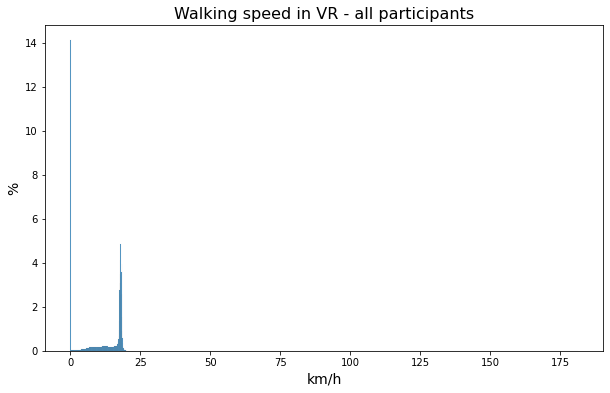

In [87]:
# Example data

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(allWalkingSpeeds,kde=False, stat='percent')


# Add labels and title
plt.xlabel('km/h', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.title('Walking speed in VR - all participants', fontsize=16)

full_path = os.path.join(savepath_walkingPaths, "walkingSpeed_VR_allParticipants_allRows.png")

plt.savefig(full_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

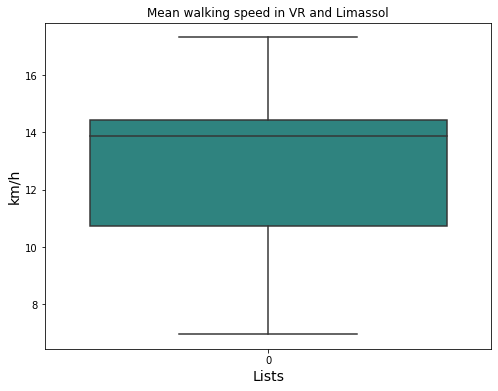

In [88]:

plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=allWalkingSpeed_means, palette='viridis')


# Add labels and title
plt.xlabel('Lists', fontsize=14)
plt.ylabel('km/h', fontsize=14)
plt.title('Mean walking speed in VR and Limassol', fontsize=12)

# save plot

full_path = os.path.join(savepath_walkingPaths, "mean_walking_speeds_allRows.png")

plt.savefig(full_path, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

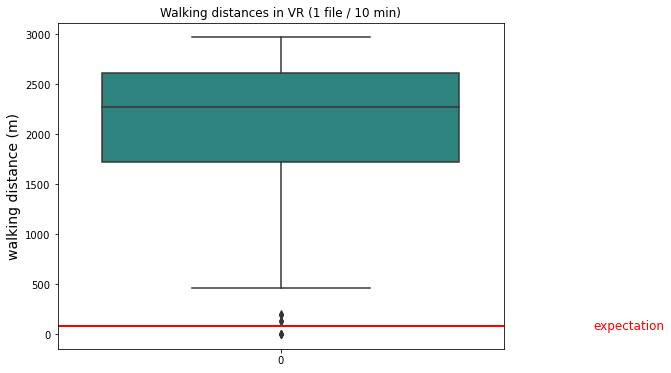

In [89]:

plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=allWalkingDistances, palette='viridis')

exp_dist = (5 * (1/60)) * 1000 # 5km/h for 10 min in m 
# Add a horizontal line representing the Limassol value
plt.axhline(y=exp_dist, color='red', linestyle='-', linewidth=2)

# Add a label next to the axline
plt.text(x=0.7, y=exp_dist, s='expectation', color='red', fontsize=12, verticalalignment='center')
# 

# Add labels and title
plt.ylabel('walking distance (m)', fontsize=14)
plt.title('Walking distances in VR (1 file / 10 min)', fontsize=12)

# save plot

full_path = os.path.join(savepath_walkingPaths, 'walking_distances_Westbrook_1file_10min_allRows.png')

plt.savefig(full_path, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

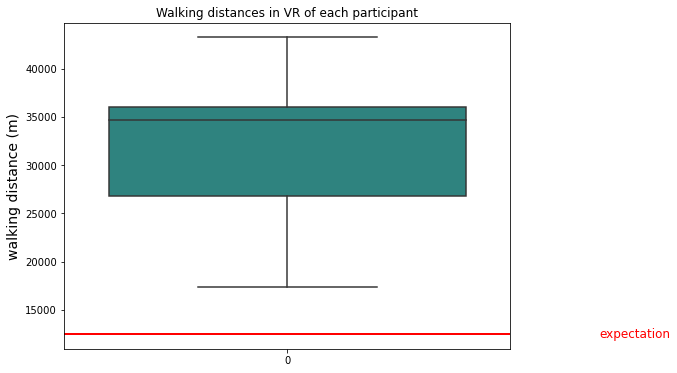

In [90]:

plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=allWalkingDistances_parts, palette='viridis')

exp_m_all = (5* 2.5)*1000 # 5km/h for 150min/2.5 hours in m
# Add a horizontal line representing the Limassol value
plt.axhline(y=exp_m_all, color='red', linestyle='-', linewidth=2)

# Add a label next to the axline
plt.text(x=0.7, y=exp_m_all, s='expectation', color='red', fontsize=12, verticalalignment='center')


# Add labels and title
plt.ylabel('walking distance (m)', fontsize=14)
plt.title('Walking distances in VR of each participant', fontsize=12)

# save plot

full_path = os.path.join(savepath_walkingPaths, 'walking_distances_Westbrook_participants_allRows.png')

plt.savefig(full_path, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()